In [1]:
import pandas as pd
import numpy as np 
import re
import functools
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from jupyterthemes import jtplot
jtplot.style()

## Generate Features
### Helper functions

In [155]:
import functools

def status(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        print(f"Beginning {func.__name__}")
        result = func(*args, **kwargs)
        print(f"Ending {func.__name__}")
        return result
    return wrapper

def replace_rare_categories(df, columns, threshold=0.01, replacement='Other'):
    for c in columns:
        freq = df[c].value_counts(normalize=True)
        mask = df[c].isin(freq[freq >= threshold].index)
        df.loc[~mask, c] = replacement
    return df

### Features using longitude, latitude, state, etc

In [156]:
@status
def generate_location_features(df):
    # bin the latitude and longitude into regions
    # 2x2 grid 
    df['lat_binned_q2'] = pd.qcut(df.city_latitude, q=2, labels=False)
    df['long_binned_q2'] = pd.qcut(df.city_longitude, q=2, labels=False)
    # 10x10 grid
    df['lat_binned_q10'] = pd.qcut(df.city_latitude, q=10, labels=False)
    df['long_binned_q10'] = pd.qcut(df.city_longitude, q=10, labels=False)
    # if any country has less than 1% occurence in data, group into 'Other'
    df = replace_rare_categories(df, ['state', 'country'], threshold=0.1)
    return df

### Features derived from the time of the sighting

In [157]:
@status
def generate_datetime_features(df):
    ### Begin
    df.date_time = pd.to_datetime(df.date_time)
    df['year'] = df.date_time.dt.year
    df['month'] = df.date_time.dt.month
    df['hour'] = df.date_time.dt.hour
    df['day'] = df.date_time.dt.day
    df['day_of_year'] = df.date_time.dt.day_of_year
    df['day_of_week'] = df.date_time.dt.dayofweek
    df['season'] = (df['month'] % 12 + 3) // 3
    df['time_of_day'] = pd.cut(df['hour'], 
                               bins=[0, 6, 12, 18, 24], 
                               labels=['Night', 'Morning', 'Afternoon', 'Evening'], 
                               include_lowest=True)
    df['is_weekend'] = df.date_time.dt.weekday >= 5
    # sine and cosine transformations
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    ### End
    return df

In [158]:
## Features from the duration text field

In [159]:
from fuzzywuzzy import process

@status
def generate_duration_features(df):
    def extract_duration_number(row):
        try: 
            n = re.search('\d+', row['duration'])[0]
            n = int(n)
        except:
            n = np.nan
        return n
    def identify_duration_unit(duration_text):
        units = ('hours', 'minutes', 'seconds', 'days', 'min', 'nights', 'sec')
        match, score = process.extract(duration_text, units)[0]
        if score >= 40:
            return match
        else:
            return 'NONE'
    df['duration_num'] = df.apply(extract_duration_number, axis=1)
    df['duration_unit'] = df['duration'].fillna('None').apply(identify_duration_unit)
    df['duration_unit'] = df['duration_unit'].replace({'min':'minutes', 'sec': 'seconds', 'NONE': 'None', 'nights': 'days'})
    df['duration_multiplier'] = df.duration_unit.map({'hours': 3600,
              'minutes': 60,
              'seconds': 1,
              'days': 86400})
    df['duration_seconds'] = df.duration_num * df.duration_multiplier
    mask = df.duration_seconds > 0
    df['log_duration_sec'] = [np.log10(x) if x>0 else np.nan for x in df.duration_seconds]
    bins = np.logspace(np.log10(df[mask]['duration_seconds'].min()), np.log10(df[mask]['duration_seconds'].max()), num=50)
    df['binned_log_duration'] = pd.cut(df['log_duration_sec'], bins=bins, labels=False)
    return df

In [184]:
# load topic model results from previous notebook
df = pd.read_pickle('features_and_topics.pickle')

In [185]:
feature_df = (df
 .pipe(generate_location_features)
 .pipe(generate_datetime_features)
 .pipe(generate_duration_features))

Beginning generate_location_features
Ending generate_location_features
Beginning generate_datetime_features
Ending generate_datetime_features
Beginning generate_duration_features


Ending generate_duration_features


In [186]:
categories = ['country', 'city', 'state', 'shape', 'month', 'duration_unit']
for col_name in df.columns:
    if col_name.endswith('topic'):
        categories.append(col_name)
for c in categories:
    df[c] = df[c].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141189 entries, 0 to 141260
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   summary              141189 non-null  object        
 1   country              141189 non-null  category      
 2   city                 140713 non-null  category      
 3   state                141189 non-null  category      
 4   date_time            138532 non-null  datetime64[ns]
 5   shape                134932 non-null  category      
 6   duration             133599 non-null  object        
 7   stats                141189 non-null  object        
 8   report_link          141189 non-null  object        
 9   text                 141189 non-null  object        
 10  posted               138532 non-null  object        
 11  city_latitude        115386 non-null  float64       
 12  city_longitude       115386 non-null  float64       
 13  cleaned_text  

In [187]:
df.describe()

,city_latitude,city_longitude,lat_binned_q2,long_binned_q2,lat_binned_q10,long_binned_q10,year,hour,day,day_of_year,...,hour_sin,hour_cos,day_week_sin,day_week_cos,day_sin,duration_num,duration_multiplier,duration_seconds,log_duration_sec,binned_log_duration
count,115386.000000,115386.000000,115386.000000,115386.000000,115386.000000,115386.000000,138532.000000,138532.000000,138532.000000,138532.000000,...,138532.000000,1.385320e+05,138532.000000,138532.000000,138532.000000,123718.000000,135128.000000,1.195190e+05,119418.000000,100374.000000
mean,38.696612,-95.101006,0.499905,0.500000,4.498683,4.498709,2009.121402,15.273966,15.177612,192.595617,...,-0.331832,4.078395e-01,-0.058231,-0.027172,-0.058231,12.616604,1025.179297,3.796098e+03,2.156115,1.772591
std,5.736847,18.123374,0.500002,0.500002,2.871210,2.872713,9.610487,7.800675,8.879900,99.672967,...,0.608303,5.945814e-01,0.718864,0.692179,0.718864,90.235406,8044.112832,2.778892e+05,0.929372,0.853414
min,-31.941922,-176.627400,0.000000,0.000000,0.000000,0.000000,1969.000000,0.000000,1.000000,1.000000,...,-1.000000,-1.000000e+00,-0.974928,-0.900969,-0.974928,0.000000,1.000000,0.000000e+00,0.000000,0.000000
25%,34.223597,-112.953500,0.000000,0.000000,2.000000,2.000000,2004.000000,9.000000,7.000000,113.000000,...,-0.866025,6.123234e-17,-0.781831,-0.900969,-0.781831,2.000000,1.000000,3.000000e+01,1.477121,1.000000
50%,39.273300,-89.073150,0.000000,0.500000,4.000000,4.500000,2011.000000,19.000000,15.000000,197.000000,...,-0.500000,7.071068e-01,0.000000,-0.222521,0.000000,5.000000,60.000000,1.800000e+02,2.255273,2.000000
75%,42.352576,-80.332976,1.000000,1.000000,7.000000,7.000000,2016.000000,21.000000,23.000000,274.000000,...,0.000000,8.660254e-01,0.781831,0.623490,0.781831,15.000000,60.000000,6.000000e+02,2.778151,2.000000
max,70.639300,130.879729,1.000000,1.000000,9.000000,9.000000,2022.000000,23.000000,31.000000,366.000000,...,1.000000,1.000000e+00,0.974928,1.000000,0.974928,23000.000000,86400.000000,8.280000e+07,7.918030,5.000000


In [219]:
df['duration_seconds'] = df['duration_seconds'].fillna(0)
df['log_duration_sec'] = df['log_duration_sec'].fillna(0)

C:\Users\Connor\AppData\Local\Temp\ipykernel_12764\1441763984.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['duration_seconds'] = df['duration_seconds'].fillna(0)
C:\Users\Connor\AppData\Local\Temp\ipykernel_12764\1441763984.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_duration_sec'] = df['log_duration_sec'].fillna(0)


In [188]:
length_before = len(df)
df = df.dropna(subset='city_latitude')
print(f'dropped {length_before - len(df)} rows')

dropped 25803 rows


In [243]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

mms = MinMaxScaler()
df[['latitude_scaled', 'longitude_scaled', 'duration_scaled']] \
= mms.fit_transform(df[['city_latitude', 'city_longitude', 'duration_seconds']])

ss = StandardScaler()
ss_keys = ['year', 'month', 'hour', 'day_of_week', 'season', 'day', 'day_of_year', 'duration_multiplier']
ss_scaled = [k + '_scaled' for k in ss_keys]

df[ss_scaled] = ss.fit_transform(df[ss_keys])


C:\Users\Connor\AppData\Local\Temp\ipykernel_12764\3361010561.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['latitude_scaled', 'longitude_scaled', 'duration_scaled']] \
C:\Users\Connor\AppData\Local\Temp\ipykernel_12764\3361010561.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ss_scaled] = ss.fit_transform(df[ss_keys])


In [244]:
df.loc[:, df.columns.str.contains('_scaled')]

,latitude_scaled,longitude_scaled,duration_scaled,year_scaled,month_scaled,hour_scaled,day_of_week_scaled,season_scaled,day_scaled,day_of_year_scaled,duration_multiplier_scaled
0,0.777296,0.176649,0.000000e+00,1.018560,-0.267470,0.337653,1.427853,0.303317,0.878172,-0.192315,-0.117295
1,0.714710,0.337248,2.173913e-04,1.018560,-0.267470,0.596134,1.427853,0.303317,0.878172,-0.192315,0.336418
2,0.682366,0.319124,1.811594e-07,1.018560,-0.267470,0.983856,-0.084601,0.303317,0.540462,-0.222408,-0.124857
3,0.723138,0.303892,1.449275e-06,1.018560,-0.267470,-1.988676,0.419550,0.303317,0.653032,-0.212377,-0.117295
5,0.640819,0.194068,3.019324e-07,1.018560,0.039767,-1.988676,0.923702,0.303317,-1.035516,-0.061914,-0.124857
...,...,...,...,...,...,...,...,...,...,...,...
141256,0.713771,0.337605,0.000000e+00,1.232621,1.575952,0.983856,1.427853,-1.535840,0.427892,1.603212,-0.117295
141257,0.687932,0.280710,0.000000e+00,1.339651,-1.189181,-1.988676,-0.588752,-0.616262,-0.697807,-1.255589,-0.117295
141258,0.719330,0.287213,5.434783e-07,0.376378,-0.881944,-1.730195,-1.092903,-0.616262,1.666161,-0.733983,-0.124857
141259,0.775908,0.193633,0.000000e+00,-1.550168,0.039767,-0.825511,0.419550,0.303317,0.653032,0.088549,NaN


In [245]:
df.to_pickle('feature_df_scaled.pickle')

In [5]:
import pandas as pd
df = pd.read_pickle('feature_df_scaled.pickle')

## OHE topics

In [6]:
ohe_hdp = pd.get_dummies(df['hdp_topics'], prefix='hdp')
ohe_lda = pd.get_dummies(df['lda_topics'], prefix='lda')
ohe_shape = pd.get_dummies(df['shape'], prefix='shape')

In [7]:
df.columns

Index(['summary', 'country', 'city', 'state', 'date_time', 'shape', 'duration',
       'stats', 'report_link', 'text', 'posted', 'city_latitude',
       'city_longitude', 'cleaned_text', 'cleaned_summary', 'lda_topics',
       'hdp_topics', 'lat_binned_q2', 'long_binned_q2', 'lat_binned_q10',
       'long_binned_q10', 'year', 'month', 'hour', 'day', 'day_of_year',
       'day_of_week', 'season', 'time_of_day', 'is_weekend', 'hour_sin',
       'hour_cos', 'day_week_sin', 'day_week_cos', 'day_sin', 'duration_num',
       'duration_unit', 'duration_multiplier', 'duration_seconds',
       'log_duration_sec', 'binned_log_duration', 'latitude_scaled',
       'longitude_scaled', 'duration_scaled', 'year_scaled', 'month_scaled',
       'hour_scaled', 'day_of_week_scaled', 'season_scaled', 'day_scaled',
       'day_of_year_scaled', 'duration_multiplier_scaled'],
      dtype='object')

In [16]:
time_features = ['hour_scaled', 'day_scaled', 'month_scaled','day_of_week_scaled','year_scaled']
location_features = ['latitude_scaled', 'longitude_scaled']
other_features = ['duration_scaled'] 
# ohe_features = [ohe_hdp, ohe_lda, ohe_shape]
input_df = pd.concat(
    (df.loc[:, time_features + location_features + other_features], ohe_hdp, ohe_lda),
axis=1)
input_df = input_df.fillna(0)

In [17]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115386 entries, 0 to 141260
Columns: 150 entries, hour_scaled to lda_9
dtypes: float64(8), uint8(142)
memory usage: 23.5 MB


<AxesSubplot:>

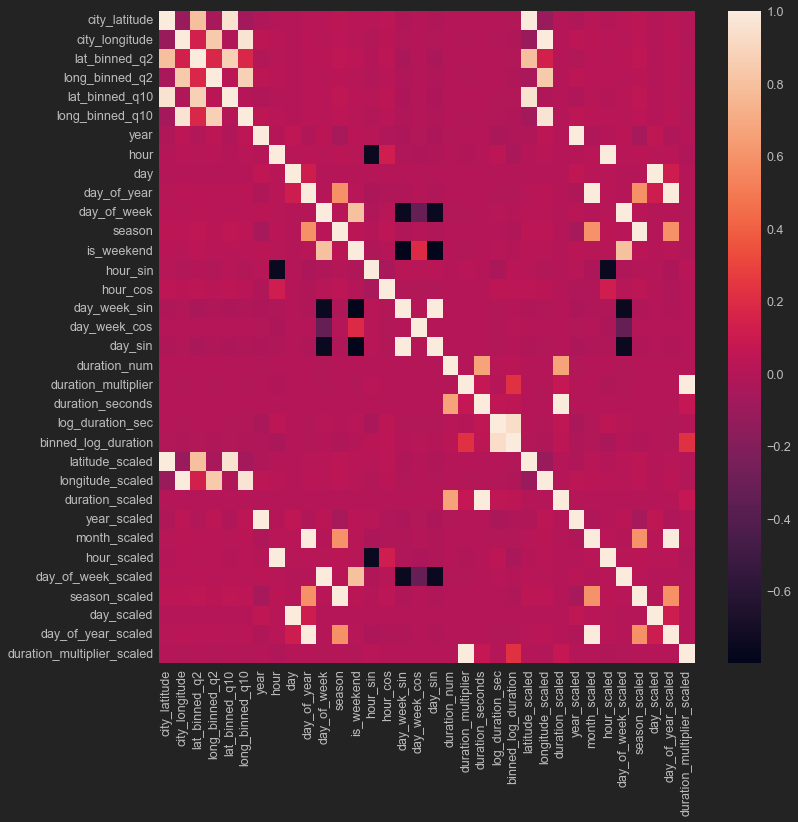

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style()
fig, ax = plt.subplots(1, 1, figsize=(12,12))
sns.heatmap(df.corr(), ax=ax)

In [12]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(input_df.fillna(input_df.mean()), test_size=0.1)

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103847 entries, 90181 to 39714
Columns: 150 entries, hour_scaled to lda_9
dtypes: float64(8), uint8(142)
memory usage: 21.2 MB


## Dimensionality reduction

In [14]:
from sklearn.decomposition import PCA, FastICA
import umap

X = train

X_pca = PCA(n_components=10).fit_transform(X)
X_ica = FastICA(n_components=10).fit_transform(X)
X_umap = umap.UMAP(n_components=10).fit_transform(X)

C:\Users\Connor\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(
Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x000002421C3FC820>
Traceback (most recent call last):
  File "C:\Users\Connor\anaconda3\lib\site-packages\llvmlite\binding\executionengine.py", line 171, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):
KeyboardInterrupt: 


In [15]:
X = train
um = umap.UMAP(n_components=10)
X_umap = um.fit_transform(X)

In [444]:
um.local_connectivity

1.0

In [ ]:
X_pca_2d = PCA(n_components=2).fit_transform(X)
X_ica_2d = FastICA(n_components=2).fit_transform(X)
X_umap_2d = umap.UMAP(n_components=2).fit_transform(X)

X_pca_3d = PCA(n_components=3).fit_transform(X)
X_ica_3d = FastICA(n_components=3).fit_transform(X)
X_umap_3d = umap.UMAP(n_components=3).fit_transform(X)

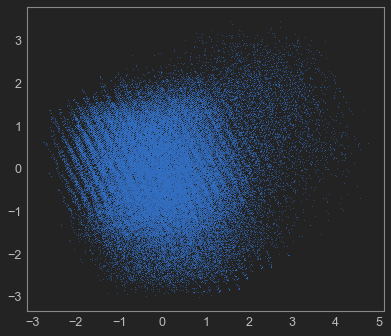

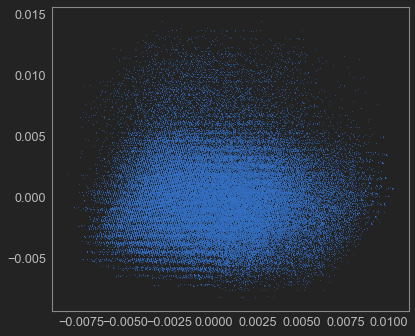

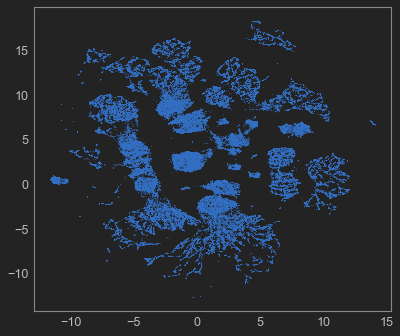

In [354]:
for emb in X_pca_2d, X_ica_2d, X_umap_2d:
    plt.scatter(emb[:,0], emb[: , 1], label=label, alpha=0.5, s=0.8)
    plt.show()

## Clustering Algorithms

In [275]:
embedding_vectors = {'pca': X_pca, 'umap': X_umap, 'ica': X_ica}
embedding_names = list(embedding_vectors.keys())
embedding_names

['pca', 'umap', 'ica']

In [308]:
from sklearn.cluster import OPTICS, AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
import pdb

SAMPLE_SIZE = 0.25
METRIC = 'silhouette'
space = [Real(0.0001, 1, prior='log-uniform', name='eps'),
        Integer(5, 200, name='min_samples'), 
        Integer(2, 10, name='n_components')]

@use_named_args(space)
def score_DBSCAN_model(**params):
    X = embeddings
    if SAMPLE_SIZE < 1:
        _, X = train_test_split(X, test_size=SAMPLE_SIZE, shuffle=True)
    dbscan = DBSCAN(**params).fit(X)
    labels = dbscan.labels_
    num_clusters = len(set(labels)) 
    if num_clusters <= 1:
        score = 0
    elif num_clusters == len(X):
        score = 0.2
    else:
        score = silhouette_score(X, labels)
    return -score

trial_results = []
for name, embeddings in embedding_vectors.items():
    print('Tuning', name)
    results = gp_minimize(func=score_DBSCAN_model, dimensions=space, n_calls=20,
                n_initial_points=1, acq_func="EI", acq_optimizer="sampling", random_state=42,verbose=True)

    trial_results.append((name, results))

Tuning pca
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 6.7230
Function value obtained: 0.3034
Current minimum: 0.3034
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 0.3790
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 0.4160
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 6.4880
Function value obtained: 0.3723
Current minimum: 0.0000
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 8.5340
Function value obtained: -0.0299

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 31.9022
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 7.2650
Function value obtained: 0.2950
Current minimum: 0.0000
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 31.9012
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 31.7072
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 31.5052
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 6 started. Searching for the ne

In [359]:
# train models from best parameters and predict clusters
models = {}
for emb_name, results in trial_results:
    model = DBSCAN(eps=results.x[0], min_samples=results.x[1], n_jobs=-1)
    models[emb_name] = model
models

{'pca': DBSCAN(eps=0.9609357023791337, min_samples=142, n_jobs=-1),
 'umap': DBSCAN(eps=0.936333307318207, min_samples=101, n_jobs=-1),
 'ica': DBSCAN(eps=0.009917657515373364, min_samples=11, n_jobs=-1)}

In [361]:
emb_clusters = {}
for emb_name in models.keys():
    X = embedding_vectors[emb_name]
    model = models[emb_name]
    print(f'Training {emb_name}')
    labels = model.fit_predict(X)
    emb_clusters[emb_name] = labels

Training pca
Training umap
Training ica


In [362]:
emb_clusters

{'pca': array([ 0,  0,  0, ..., -1,  0,  0], dtype=int64),
 'umap': array([0, 1, 1, ..., 6, 2, 0], dtype=int64),
 'ica': array([0, 0, 0, ..., 0, 0, 0], dtype=int64)}

In [ ]:
 legend_elements = []
        for label in unique_labels:
            axes[i, j].scatter(emb_2d[labels == label , 0], emb_2d[labels == label , 1],
                               label=label, alpha=0.5, s=0.8)
            if label in largest_clusters:  # Check if current cluster is among the largest
                


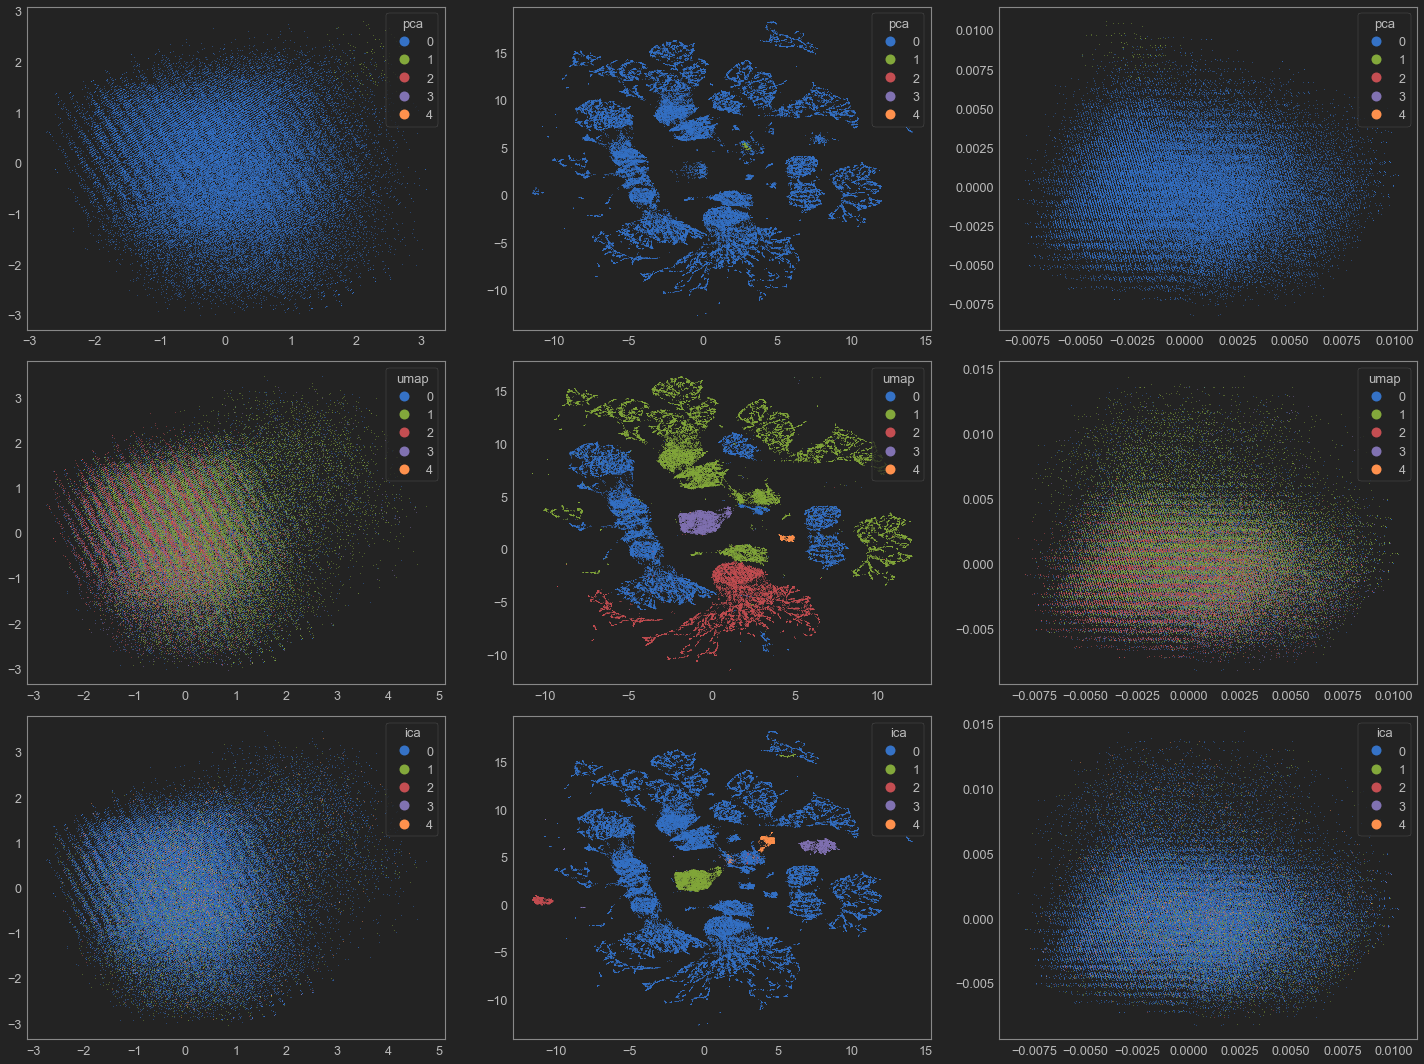

In [415]:
from matplotlib.pyplot import Line2D
# plot the clusters in different colors
fig, axes = plt.subplots(3,3, figsize=(20, 15))
embs = [X_pca_2d, X_umap_2d, X_ica_2d]
for i, emb_name in enumerate(['pca', 'umap', 'ica']):
    labels = emb_clusters[emb_name]
    unique_labels = set(clusters)
    cluster_sizes = {label: sum(labels == label) for label in set(labels)}
    # get 5 largest
    largest_clusters = sorted(cluster_sizes, key=cluster_sizes.get, reverse=True)[:5]
    
    for j, emb_2d in enumerate(embs):
        legend_elements = []
        for label in unique_labels:            
            axes[i, j].scatter(emb_2d[labels == label , 0], emb_2d[labels == label , 1],
                               label=label, alpha=0.5, s=0.8)
            legend_elements.append(Line2D([0], [0], linewidth=0.0001, marker='o', color='w', 
                                              label=label, markerfacecolor='C'+str(label), markersize=10))
        axes[i,j].legend(handles=legend_elements, title=f'{emb_name}', title_fontsize='13', loc='upper right')

jtplot.style(grid=False)
plt.tight_layout()
plt.show()

In [432]:
cluster_df = pd.concat((train,
pd.Series(emb_clusters['umap'], name='dbscan_umap_clusters', index=train.index),
pd.Series(emb_clusters['pca'], name='dbscan_pca_clusters', index=train.index),
pd.Series(emb_clusters['ica'], name='dbscan_fastica_clusters', index=train.index)), axis=1)

<AxesSubplot:ylabel='dbscan_umap_clusters'>

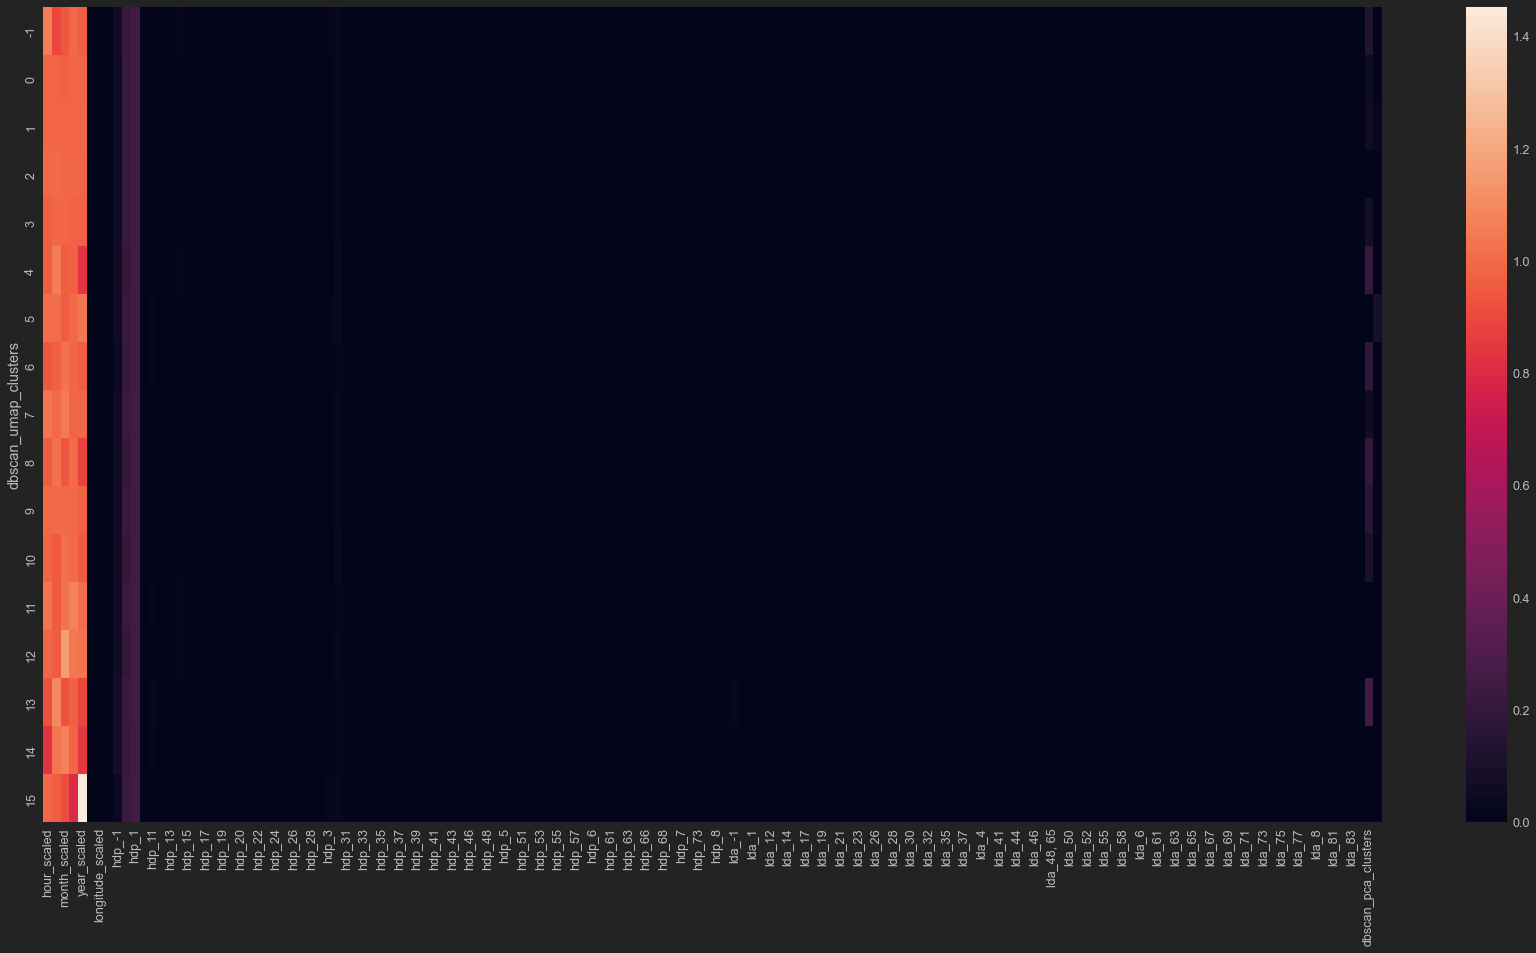

In [510]:
fig, ax = plt.subplots(1,1,figsize=(30,15))
sns.heatmap(cluster_df.groupby('dbscan_umap_clusters').var())

In [496]:
def compute_delta_variance(cluster_variances):
    overall_variances = df.var()
    delta_variances = cluster_variances.subtract(overall_variances)
    return delta_variances

delta_variances = compute_delta_variance(cluster_df.groupby('dbscan_umap_clusters').var())
delta_variances


C:\Users\Connor\AppData\Local\Temp\ipykernel_12764\1950087180.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  overall_variances = df.var()


,binned_log_duration,city_latitude,city_longitude,day,day_of_week,day_of_week_scaled,day_of_year,day_of_year_scaled,day_scaled,day_sin,...,lda_9,log_duration_sec,long_binned_q10,long_binned_q2,longitude_scaled,month_scaled,season,season_scaled,year,year_scaled
dbscan_umap_clusters,,,,,,,,,,,,,,,,,,,,,
-1,NaN,NaN,NaN,NaN,NaN,-0.006666,NaN,NaN,-0.107883,NaN,...,NaN,NaN,NaN,NaN,3.831579e-04,-0.061581,NaN,NaN,NaN,-0.036389
0,NaN,NaN,NaN,NaN,NaN,-0.019147,NaN,NaN,-0.020051,NaN,...,NaN,NaN,NaN,NaN,7.542277e-07,-0.026921,NaN,NaN,NaN,-0.016645
1,NaN,NaN,NaN,NaN,NaN,-0.020873,NaN,NaN,-0.020865,NaN,...,NaN,NaN,NaN,NaN,-7.900997e-06,-0.013119,NaN,NaN,NaN,-0.006979
2,NaN,NaN,NaN,NaN,NaN,-0.012382,NaN,NaN,-0.003355,NaN,...,NaN,NaN,NaN,NaN,1.851417e-05,-0.015824,NaN,NaN,NaN,-0.019376
3,NaN,NaN,NaN,NaN,NaN,-0.028840,NaN,NaN,-0.010611,NaN,...,NaN,NaN,NaN,NaN,2.699069e-05,-0.017217,NaN,NaN,NaN,-0.032538
4,NaN,NaN,NaN,NaN,NaN,-0.034054,NaN,NaN,0.057136,NaN,...,NaN,NaN,NaN,NaN,1.809530e-05,-0.035415,NaN,NaN,NaN,-0.161235
5,NaN,NaN,NaN,NaN,NaN,-0.006151,NaN,NaN,0.005407,NaN,...,NaN,NaN,NaN,NaN,1.558484e-04,-0.045462,NaN,NaN,NaN,0.034357
6,NaN,NaN,NaN,NaN,NaN,-0.017327,NaN,NaN,-0.032977,NaN,...,NaN,NaN,NaN,NaN,-1.556758e-04,0.023865,NaN,NaN,NaN,-0.036348
7,NaN,NaN,NaN,NaN,NaN,-0.019706,NaN,NaN,-0.003151,NaN,...,NaN,NaN,NaN,NaN,4.497002e-05,0.044424,NaN,NaN,NaN,-0.008305


In [497]:
def rank_clusters_by_delta_variance(delta_variances):
    rank_clusters = delta_variances.abs().sum(axis=1).sort_values(ascending=False)
    return rank_clusters

rank_clusters = rank_clusters_by_delta_variance(delta_variances)


In [498]:
rank_clusters

dbscan_umap_clusters
 15    0.794639
 14    0.444459
 13    0.376946
 4     0.324052
 12    0.283026
-1     0.271623
 8     0.245557
 11    0.180411
 6     0.167909
 10    0.138047
 3     0.122654
 7     0.104727
 0     0.097642
 5     0.097261
 1     0.077789
 2     0.061339
 9     0.040854
dtype: float64

Text(0, 0.5, 'Features')

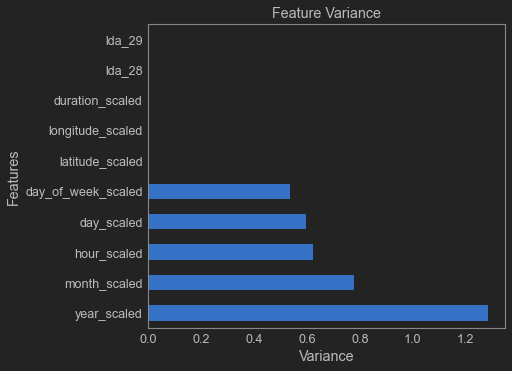

In [508]:
def rank_features_by_delta_variance(delta_variances):
    rank_features = delta_variances.abs().sum(axis=0).sort_values(ascending=False)
    return rank_features

rank_features = rank_features_by_delta_variance(delta_variances)
rank_features.iloc[:10].plot(kind='barh')
plt.title('Feature Variance')
plt.xlabel('Variance')
plt.ylabel('Features')


In [445]:
# Bert
from transformers import DistilBertModel, DistilBertTokenizer
import torch
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

GENERATE = False

if GENERATE:
    embeddings = []
    tokens = feature_df['summary'].dropna().apply(tokenizer.tokenize)
    for t in tokens:
        input_ids = torch.tensor([tokenizer.convert_tokens_to_ids(t)])
        with torch.no_grad():
            last_hidden_states = model(input_ids)[0]
        embedding = last_hidden_states[0][0].numpy()
        embeddings.append(embedding)
        embeddings_arr = np.vstack(embeddings)
        pd.Series(embeddings, index=feature_df.summary.dropna().index).to_pickle('embeddings.pickle')
else:
    embeddings = pd.read_pickle('embeddings.pickle')
    embeddings.name = 'bert_embs'


In [446]:
embeddings_arr.shape

(141151, 768)

In [449]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=10, 
                            metric='cosine').fit_transform(embeddings_arr)

# 2D
umap_embeddings_2D = umap.UMAP(n_neighbors=15,
                               n_components=2,
                               metric='cosine').fit_transform(embeddings_arr)

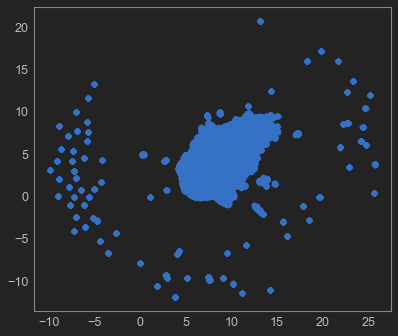

In [464]:
plt.scatter(umap_embeddings_2D.T[0],umap_embeddings_2D.T[1])

In [465]:
# 3D
umap_embeddings_3D = umap.UMAP(n_neighbors=15,
                               n_components=3,
                               metric='cosine').fit_transform(embeddings_arr)

In [486]:
topic_minus_one_renamed = max(feature_df.hdp_topics.astype('int')) + 1
feature_df.hdp_topics = feature_df.hdp_topics.replace('-1',str(topic_minus_one_renamed))
# visualise with hdp topics
colour_scale = feature_df.hdp_topics.astype('int')/max(feature_df.hdp_topics.astype('int'))

In [491]:
len(umap_embeddings_3D)

141151

ValueError: 'c' argument has 141189 elements, which is inconsistent with 'x' and 'y' with size 141151.

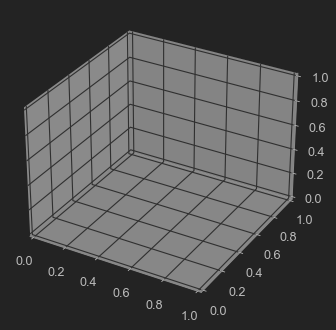

In [487]:
from mpl_toolkits.mplot3d import Axes3D
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
ax.scatter(umap_embeddings_3D[:, 0], umap_embeddings_3D[:, 1], umap_embeddings_3D[:, 2],
                    cmap='viridis', c=colour_scale)
plt.show()

0         75
1          1
2          1
3          1
4         75
          ..
141256     1
141257    75
141258     1
141259    28
141260     1
Name: hdp_topics, Length: 141189, dtype: object

In [133]:
cluster = DBSCAN(eps=0.1, min_samples=6, metric='euclidean').fit(umap_embeddings)

array([], shape=(0, 5), dtype=float64)

In [134]:
result = pd.DataFrame(umap_embeddings_2D, columns=['x', 'y'])
result['labels'] = cluster.labels_
print(len(set(result['labels'])))
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=1)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=1, cmap='hsv_r')
plt.grid(False)
#plt.colorbar()

ValueError: Length of values (142) does not match length of index (141151)

In [125]:
fig.savefig('temp.png', transparent=True, dpi=300)

In [115]:
len(embeddings)

141151

In [120]:

pd.Series(embeddings, index=feature_df.summary.dropna().index).to_pickle('embeddings.pickle')

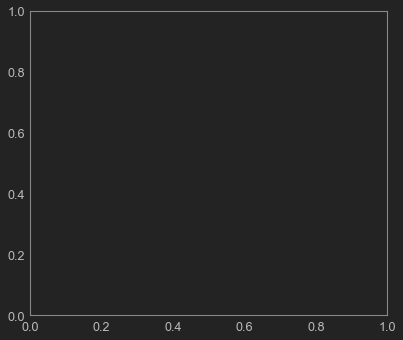